In [28]:
from inside_ns import enter_ns
from orbit3d import get_3dtrajectory
import numpy as np
import mpmath as mp
from matplotlib import pyplot as plt
from orbit2d import get_2dtrajectory, plot_2dtraj
from scipy.optimize import root_scalar

In [29]:
def get_2dtraj_in_ns(rin: mp.matrix, vin: mp.matrix, tin: float, k: float, radius: float) -> mp.matrix:
    omega = mp.sqrt(k / radius**3)
    rns = lambda t: mp.matrix([rin[0]*mp.cos(omega*(t-tin)) + vin[0]/omega*mp.sin(omega*(t-tin)),
                            rin[1]*mp.cos(omega*(t-tin)) + vin[1]/omega*mp.sin(omega*(t-tin))])

    vns = lambda t: mp.matrix([vin[0]*mp.cos(omega*(t-tin)) - rin[0]*omega*mp.sin(omega*(t-tin)),
                            vin[1]*mp.cos(omega*(t-tin)) - rin[1]*omega*mp.sin(omega*(t-tin))])

    return rns, vns

In [30]:
def plot_2dtraj_in_ns(rin: mp.matrix, vin: mp.matrix, tin: float, k: float, radius: float, n_points: int = 10_000) -> mp.matrix:
    omega = mp.sqrt(k / radius**3)
    rns, _ = get_2dtraj_in_ns(rin, vin, tin, k, radius)

    tsns = mp.linspace(tin, tin + 2*mp.pi/omega, n_points)
    rsns = np.array([rns(tns) for tns in tsns])

    plt.plot(rsns.T[0], rsns.T[1])

In [31]:
def find_ns_exit(rin: mp.matrix, vin: mp.matrix, tin: float, k: float, radius: float, n_points: int = 10_000) -> tuple:
    omega = mp.sqrt(k / radius**3)
    r2d, v2d = get_2dtraj_in_ns(rin, vin, tin, k, radius)
    to_root = lambda angle: mp.norm(r2d(angle/omega+tin)) - radius

    angles = mp.linspace(0, 2*mp.pi, n_points, endpoint=False)
    to_root_vals = np.array([to_root(angle) for angle in angles])
    index = np.where(to_root_vals[:-1]*to_root_vals[1:] < 0)[0][0]

    angle_exit = root_scalar(to_root, bracket=(0, angles[index+1])).root

    return r2d(angle_exit/omega+tin), v2d(angle_exit/omega+tin), angle_exit/omega+tin

In [32]:
def get_2dtraj_through_ns(r02d: mp.matrix, v02d: mp.matrix, k: float, radius: float, t0: float = 0.) -> tuple:
    infall = get_2dtrajectory(r02d, v02d, k)
    thetain, r2din, rdotin, thetadotin, tin = enter_ns(r02d, v02d, k, radius)

    rin = mp.matrix([r2din*mp.cos(thetain), r2din*mp.sin(thetain)])
    vin = mp.matrix([rdotin*mp.cos(thetain) - r2din*thetadotin*mp.sin(thetain),
                    rdotin*mp.sin(thetain) + r2din*thetadotin*mp.cos(thetain)])

    rout, vout, tout = find_ns_exit(rin, vin, tin, k, radius)

    tinfall = lambda theta: infall[-1](theta) - tout

    outfall = get_2dtrajectory(rout, vout, k)

    return (infall[0][0], thetain, outfall[0][1], outfall[0][2]), infall[1:-1] + (tinfall, ), outfall[1:]

In [33]:
def plot_2dtraj_through_ns(r02d: mp.matrix, v02d: mp.matrix, k: float, radius: float, n_points: int = 10_000) -> tuple:
    theta_info, infall, outfall = get_2dtraj_through_ns(r02d, v02d, k, radius)
    thetas_infall = mp.linspace(theta_info[0], theta_info[1], n_points)[1:]
    plot_2dtraj(r02d, v02d, k, n_points, (thetas_infall[1], thetas_infall[-1]))

    thetain, r2din, rdotin, thetadotin, tin = enter_ns(r02d, v02d, k, radius)

    rin = mp.matrix([r2din*mp.cos(thetain), r2din*mp.sin(thetain)])
    vin = mp.matrix([rdotin*mp.cos(thetain) - r2din*thetadotin*mp.sin(thetain),
                    rdotin*mp.sin(thetain) + r2din*thetadotin*mp.cos(thetain)])

    plot_2dtraj_in_ns(rin, vin, tin, k, radius)

    thetas_outfall = mp.linspace(theta_info[-2], theta_info[-1], n_points)[1:]
    rout, vout, tout = find_ns_exit(rin, vin, tin, k, radius)

    plot_2dtraj(rout, vout, k, n_points, (thetas_outfall[0], thetas_outfall[-2]))


In [34]:
d0, b, v0 = 1.e20, 6e3, -200.
k = 1.32712e11

r02d, v02d = mp.matrix([d0, b]), mp.matrix([v0, 0.])

In [35]:
radius = 10.
enter_ns(r02d, v02d, k, radius)

(mpf('1.6541470177955854836682192399166524410247802734375'),
 mpf('9.9999999999999997773316928489592310596124482669522869'),
 mpf('-110192.74023273947037213387156213579739310214296400126'),
 mpf('12000.000000000000534403937162497863306153127582999147'),
 mpf('499999999999506808.45041218549761602135541987743071627'))

[-25, 25, -25, 25]

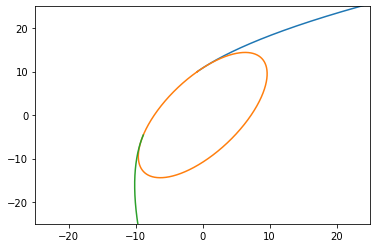

In [36]:
plot_2dtraj_through_ns(r02d, v02d, k, radius)
plt.axis([-25,25,-25,25])